<a href="https://colab.research.google.com/github/victorviro/Machine-Learning-Python/blob/master/Support_Vector_Machines_explained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of contents


1. [Introduction](#1)
2. [Linear SVM classification](#2)
    1. [Soft margin classification](#2.1)
    2. [Decision function and predictions](#2.2)
    3. [Training objective](#2.3)
    4. [Hinge loss](#2.4)
3. [Nonlinear SVM classification](#3)
    1. [Polynomial kernel](#3.1)
    2. [Adding similarity features](#3.2)
    3. [Gaussian RBF kernel](#3.3)
    4. [Computational complexity](#3.4)
4. [SVM regression](#4)
5. [Deeper understanding of SVM](#5)
    7. [The dual problem](#5.1)
    8. [Kernelized SVM](#5.2)
6. [References](#6)





# Introduction <a name="1"></a>

A Support Vector Machine (SVM) is a very powerful and **versatile** ML model, capable of performing **linear or nonlinear classification, regression**, and even outlier detection. It is one of the most popular models in ML. SVMs are particularly well suited for classification of complex but **small- or medium-sized datasets**.

This notebook will explain the core concepts of SVMs, how to use them, and how they work.

# Linear SVM classification <a name="2"></a>

The fundamental idea behind SVMs is best explained with some pictures. Figure 5-1 shows part of the [iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set). The two classes can clearly be separated easily with a straight line (they are linearly separable). The left plot shows the decision boundaries of three possible linear classifiers. The model whose decision boundary is represented by the dashed line is so bad that it does not even separate the classes properly. The other two models work perfectly on
this training set, but their decision boundaries come so close to the instances that these models will probably not perform as well on new instances. In contrast, the solid line in the plot on the right represents the decision boundary of an SVM classifier; this line not only **separates the two classes but also stays as far away from the closest training instances as possible**. You can think of an SVM classifier as fitting the **widest possible street** (represented by the parallel dashed lines) between the classes. This is called **large margin classification**.

![alt text](https://i.ibb.co/G2Z4vk4/large-margin-png.png)

Notice the decision is fully determined by the **instances located on the edge of the street**. These instances are called the **support vectors** (they are circled in Figure 5-1).

- SVMs are **sensitive to the feature scales**, as you can see in Figure 5-2: on the left plot, the vertical scale is much larger than the horizontal scale, so the widest possible street is close to horizontal. After feature scaling (e.g., using Scikit-Learn’s StandardScaler), the decision boundary looks much better (on the right plot).

![alt text](https://i.ibb.co/vPMqhWV/svm-scale.png)


### Soft margin classification <a name="2.1"></a>

If we strictly impose that all **instances be off the street** and on the right side, this is called **hard margin classification**. There are two main issues with hard margin classification. First, it only **works if the data is linearly separable**, and second, it is quite **sensitive to outliers**.

![texto alternativo](https://i.ibb.co/BfdXcYZ/outlier-hard-margin.png)

To avoid these issues it is preferable to use a more flexible model. The objective is to find a good **balance between keeping the street as large as possible and limiting the margin violations** (i.e., instances that end up in the middle of the street or even on the wrong side). This is called **soft margin classification**.

In Scikit-Learn’s SVM classes, you can control this balance using the C hyperparameter: a **smaller C** value leads to a **wider street but more margin violations**. Figure 5-4 shows the decision boundaries and margins of two soft margin SVM classifiers on a nonlinearly separable dataset. On the left, using a low C value the margin is quite large, but many instances end up on the street. On the right, using a high C value the classifier makes fewer margin violations but ends up with a smaller margin. However, it seems likely that the first classifier will generalize better: even on this training set, it makes fewer prediction errors, since most of the margin violations are actually on the correct side of the decision boundary.

![alt text](https://i.ibb.co/Th3CrPc/svm-c.png)

If your SVM model is **overfitting**, you can try regularizing it by **reducing C**.

The following Scikit-Learn code loads the iris dataset, scales the features, and then trains a linear SVM model (using the `LinearSVC` class with `C = 1` and the hinge loss function, described later) to detect Iris-Virginica flowers. The resulting model is represented on the left of Figure 5-4.


In [1]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)] # petal length, petal width
y = (iris["target"] == 2).astype(np.float64) # Iris-Virginica
svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("linear_svc", LinearSVC(C=1, loss="hinge")),
            ])
svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linear_svc',
                 LinearSVC(C=1, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=None, tol=0.0001,
                           verbose=0))],
         verbose=False)

We can use the model to make predictions:

In [2]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

Unlike Logistic Regression classifiers, SVM classifiers **do not output probabilities** for each class.

The `LinearSVC` class regularizes the bias term, so you should center the training set first by subtracting its mean. This is automatic if you scale the data using the StandardScaler.


Alternatively, you could use the `SVC` class, using `SVC(kernel="linear", C=1)`, but it is much slower, especially with large training sets. Another option is to use the `SGDClassifier` class, with `SGDClassifier(loss="hinge", alpha=1/(m*C))`. This applies regular Stochastic Gradient Descent to train a linear SVM classifier. It does not converge as fast as the `LinearSVC` class, but it can be useful to handle huge datasets that do not fit in memory.

### Decision function and predictions <a name="2.2"></a>

The linear SVM classifier model predicts the class of a new instance $\boldsymbol{x}$ by computing the **decision function** 
$\boldsymbol{w}^T\boldsymbol{x}+b = w_1x_1+...+w_nx_n+b$ : if the result is positive, the predicted class ŷ is the positive class (1), or else it is the negative class (0).

$$\hat{y}=\begin{cases}
              0&\text{if }\boldsymbol{w}^T\boldsymbol{x}+b<0,\\
              1&\text{if }\boldsymbol{w}^T\boldsymbol{x}+b\geq0.
\end{cases}$$



Figure 5-12 shows the decision function that corresponds to the model on the left of Figure 5-4: it is a two-dimensional plane since this dataset has two features (petal width and petal length). The decision boundary is the set of points where the decision function is equal to 0: it is the intersection of two planes, which is a straight line (represented by the thick solid line).

![texto alternativo](https://i.ibb.co/w6RmWfh/decision-boundary-iri-df.png)

The dashed lines represent the points where the decision function is equal to 1 or –1: they are parallel and at equal distance to the decision boundary, forming a margin around it. Training a linear SVM classifier means **finding the value of $\boldsymbol{w}$ and $b$ that make this margin as wide as possible while avoiding margin violations (hard margin) or limiting them (soft margin)**.

### Training objective <a name="2.3"></a>

Consider the slope of the decision function: it is equal to the norm of the weight vector, $||\boldsymbol{w}||$. If we divide this slope by 2, the points where the decision function is equal to ±1 are going to be twice as far away from the decision boundary. In other words, dividing the slope by 2 will multiply the margin by 2. It is easier to visualize in 2D in Figure 5-13. The smaller the weight vector $\boldsymbol{w}$, the larger the margin.

![texto alternativo](https://i.ibb.co/4FRZ6N7/weigh-vector-margin.png)

So we want to minimize $||\boldsymbol{w}||$ to get a large margin. However, if we also want to avoid any margin violation (hard margin), then we need the decision function to be greater than 1 for all positive training instances, and lower than -1 for negative training instances. If we define $t^{(i)}=-1$ for negative instances (if $y^{(i)}=0$) and $t^{(i)}=1$ for positive instances (if $y^{(i)}=1$), then we can express this constraint as $t^{(i)}(\boldsymbol{w}^T\boldsymbol{x}^{(i)}+b)\geq1$ for all instances.

We can, therefore, express the hard margin linear SVM classifier objective as a constrained optimization problem using the next equation.


$$\min\limits_{\boldsymbol{w},b}\frac{1}{2}\boldsymbol{w}^T\boldsymbol{w}$$

subject to

$$t^{(i)}(\boldsymbol{w}^T\boldsymbol{x}^{(i)}+b)\geq1,i=1,...,m$$


**Note**: We are minimizing $\frac{1}{2}||\boldsymbol{w}||^2$, rather than minimizing $||\boldsymbol{w}||$ because $\frac{1}{2}||\boldsymbol{w}||^2$ has a nice and simple derivative (it is just $\boldsymbol{w}$) while $||\boldsymbol{w}||$ is not differentiable at $\boldsymbol{w}=0$.

To get the soft margin objective, we need to introduce a *slack variable* $\zeta^{(i)}\geq0$ for each instance $\zeta^{(i)}$ measures how much the $i^{th}$ instance is allowed to violate the margin. We now have two conflicting objectives: making the slack variables as small as possible to reduce the margin violations, and making $\frac{1}{2}\boldsymbol{w}^T\boldsymbol{w}$ as small as possible to increase the margin. This is where the `C` hyperparameter comes in: it allows us to define the tradeoff between these two objectives. This gives us the constrained optimization problem in the next equation.


$$\min\limits_{\boldsymbol{w},b}\frac{1}{2}\boldsymbol{w}^T\boldsymbol{w}+C\sum_{i=1}^{m}\zeta^{(i)}$$

subject to

$$\mspace{6mu}t^{(i)}(\boldsymbol{w}^T\boldsymbol{x}^{(i)}+b)\geq1-\zeta^{(i)}\text{ and }\zeta^{(i)}\geq0,i=1,...,m$$


**Note**: The hard margin and soft margin problems are both convex quadratic optimization problems with linear constraints. Such problems are known as *Quadratic Programming* (QP) problems and there are a variety of techniques to solve them.

### Hinge loss <a name="2.4"></a>

The optimization problem

$$\min\limits_{\boldsymbol{w},b}\frac{1}{2}\boldsymbol{w}^T\boldsymbol{w}+C\sum_{i=1}^{m}\zeta^{(i)}$$

subject to

$$\mspace{6mu}t^{(i)}(\boldsymbol{w}^T\boldsymbol{x}^{(i)}+b)\geq1-\zeta^{(i)}\text{ and }\zeta^{(i)}\geq0,i=1,...,m$$

can be equivalently formulated as

$$\min\limits_{\boldsymbol{w},b}\frac{1}{2}\boldsymbol{w}^T\boldsymbol{w}+C\sum_{i=1}^{m}\text{max}(0,t^{(i)}(\boldsymbol{w}^T\boldsymbol{x}^{(i)}+b))$$

where we make use of the [**hinge loss**](https://en.wikipedia.org/wiki/Hinge_loss). This is the form that is directly optimized by `LinearSVC`, but the famous kernel trick (discussed in the next section) cannot be applied.

The derivative (slope) of the function $\text{max}(0, 1-t)$ is equal to $-1$ if $t<1$ and $0$ if $t>1$. It is not
differentiable at $t=1$, but we can still use Gradient Descent using any subderivative at $t=1$ (i.e., any
value between $-1$ and $0$).

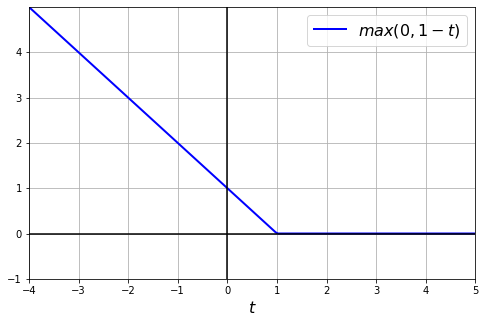

In [3]:
import matplotlib.pyplot as plt

t = np.linspace(-4, 5, 200)
h = np.where(1 - t < 0, 0, 1 - t)  # max(0, 1-t)

plt.figure(figsize=(8,5))
plt.plot(t, h, "b-", linewidth=2, label="$max(0, 1 - t)$")
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.yticks(np.arange(-1, 5, 1))
plt.xlabel("$t$", fontsize=16)
plt.axis([-4, 5, -1, 5])
plt.legend(loc="upper right", fontsize=16)
plt.show()

# Nonlinear SVM classification <a name="3"></a>

Many datasets are **not linearly separable**. One approach to handling nonlinear datasets is to **add more features**, such as polynomial features. In some cases, this **can result in a linearly separable dataset**.

Consider the left plot in Figure 5-5: it represents a simple dataset with just one feature $x_1$. This dataset is not linearly separable, as you can see. But if you add a second feature $x_2=x_1^2$, the resulting 2D dataset is perfectly linearly separable.

![texto alternativo](https://i.ibb.co/Ydd5pqx/svm-3.png)

To implement this idea using Scikit-Learn, you can create a `Pipeline` containing a `PolynomialFeatures` transformer, followed by a `StandardScaler` and a `LinearSVC`.




In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import LinearSVC

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge"))
    ])

### Polynomial kernel <a name="3.1"></a>

Adding polynomial features can work great but at a low polynomial degree it cannot deal with very complex datasets, and with a high polynomial degree, it creates a **huge number of features**, making the model too **slow**.

Fortunately, when using SVMs you can apply a mathematical technique called the **kernel trick**. It makes it possible to get the **same result as if you added many polynomial features**, even with very high-degree polynomials, **without actually having to add them**. So there is no combinatorial explosion of the number of features since you don’t add any features. This trick is implemented by the `SVC` class.

In [5]:
from sklearn.svm import SVC
poly_kernel_svm_clf = Pipeline([
                        ("scaler", StandardScaler()),
                        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
                        ])

This code prepares an SVM classifier using a $3^{\text{rd}}$ -degree polynomial kernel. If your model is **overfitting**, you might want to **reduce the polynomial degree**. Conversely, if it is underfitting, you can try increasing it. The hyperparameter `coef0` controls how much the model is influenced by high-degree polynomials versus low-degree polynomials.

### Adding similarity features <a name="3.2"></a>

Another technique to tackle nonlinear problems is to add features computed using a **similarity function** that measures how much each instance resembles a particular landmark. For example, let’s take the one-dimensional dataset discussed earlier and add two landmarks to it at $x_1=-2$ and $x_1=1$ (see the left plot in Figure 5-8). Next, let’s define the similarity function to be the Gaussian Radial Basis Function (RBF) with $\gamma=0.3$ (see equation).
$$\phi_{\gamma}(\boldsymbol{x},l)=e^{(-\gamma||\boldsymbol{x}-l||^2)}$$

It is a bell-shaped function varying from 0 to 1. Now we are ready to compute the new features. For example, let’s look at the instance $x_1=-1$: it is located at a distance of $1$ from the first landmark, and $2$ from the second landmark. Therefore its new features are $x_2=e^{(-0.3\times 1^2 )}\approx0.74$ and $x_3=e^{(-0.3\times 2^2 )}\approx0.30$. The plot on the right of Figure 5-8 shows the transformed dataset (applying the procedure for all instances and dropping the original features). As you can see, it is now linearly separable.

![texto alternativo](https://i.ibb.co/qdbdmP7/s-f-rbf.png)

The simplest approach to select the landmarks is to create a landmark at the location of each and every instance in the dataset. This creates many
dimensions and thus increases the chances that the transformed training set will be linearly separable. The downside is that a training set with $m$ instances and $n$ features gets transformed into a training set with $m$ instances and $m$ features (assuming you drop the original features). Thus, if your training set is very large, you end up with an equally large number of features.



### Gaussian RBF kernel <a name="3.3"></a>

Just like the polynomial features method, the similarity features method can be useful, but it may be **computationally expensive** to compute all the additional features, especially on large training sets. However, once
again the **kernel trick** does its SVM magic: it makes it possible to obtain a **similar result as if you had added many similarity features, without actually having to add them**. 

Let’s try the Gaussian RBF kernel using the `SVC` class:

In [6]:
rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
    ])

This model fitted in a simple dataset is represented on the bottom left of Figure 5-9. The other plots show models trained with different values of hyperparameters `gamma` ($\gamma$) and `C`. Increasing
gamma makes the bell-shape curve narrower (see the left plot of Figure 5-8), and as a result, each instance’s range of influence is smaller: the decision boundary ends up being more irregular, wiggling around individual instances. Conversely, a small gamma value makes the bell-shaped curve wider, so instances have a larger range of influence, and the decision boundary ends up smoother. So $\gamma$ **acts like a regularization hyperparameter**: if your model is **overfitting**, you should **reduce it**, and if it is underfitting, you should increase it (similar to the `C` hyperparameter).

![texto alternativo](https://i.ibb.co/F7sXvFV/SVM-RBF.png)

Other kernels exist but are used rarely. For example, some kernels are
specialized for specific data structures. *String kernels* are sometimes used when classifying text documents or DNA sequences (using the *string subsequence kernel* or kernels based on the *Levenshtein distance*).


How can you decide **which kernel to use?** As a rule, you should always try the **linear kernel first**, especially if the training set is very large or if it has a lot of features. If the **training set is not too large**, you should try the **Gaussian RBF kernel** as well; it works well in most cases.
Then if you have spare time and computing power, you can also
experiment with a few other kernels using cross-validation and grid
search, especially if there are kernels specialized for your training
set’s data structure.

### Computational complexity <a name="3.4"></a>

The `LinearSVC` class is based on the *liblinear* library, which implements an optimized algorithm for linear SVMs. It does not support the kernel trick, but it scales almost linearly with the number of training instances and the number of features: its training time complexity is roughly $O(m\times n)$.

The algorithm takes longer if you require very high precision. This is controlled by the tolerance hyperparameter $\epsilon$ (called `tol` in Scikit-Learn). In most classification tasks, the default tolerance is fine.

The `SVC` class is based on the *libsvm* library, which implements an algorithm that supports the kernel trick. The training time complexity is usually between $O(m^2\times n)$ and $O(m^3\times n)$. This means that it gets dreadfully **slow when the number of training instances gets large** ( hundreds of thousands of instances). This algorithm is **perfect for complex but small or medium training sets**. However, it **scales well with the number of features**, especially with sparse features (i.e., when each instance has few nonzero features).

# SVM regression <a name="4"></a>

As we mentioned earlier, the SVM algorithm is quite versatile: it also supports linear and nonlinear regression. The trick is to **reverse the objective**: instead of trying to fit the largest possible street between two classes while limiting margin violations, SVM Regression tries to **fit as many instances as possible on the street while limiting margin violations** (instances off the street). The **width of the street** is controlled by a **hyperparameter** $\epsilon$. Figure 5-10 shows two linear SVM Regression models trained on some random linear data, one with a large margin ( $\epsilon = 1.5$) and the other with a small margin ($\epsilon = 0.5$).

![texto alternativo](https://i.ibb.co/HT7yvPW/svm-regression.png)

Adding more training instances within the margin does not affect the model’s predictions; thus, the model is said to be $\epsilon$-insensitive.


You can use Scikit-Learn’s `LinearSVR` class to perform linear SVM Regression (the training data should be scaled and centered first):

In [7]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5)

To tackle **nonlinear regression** tasks, you can use a **kernelized SVM** model. For example, Figure 5-11 shows SVM Regression on a random quadratic training set, using a $2^{nd}$-degree polynomial kernel. There is little regularization on the left plot (a large C value) and much more regularization on the right plot (a small C value).

![texto alternativo](https://i.ibb.co/Q81dbws/svm-regression-poly.png)

The following code produces the model represented on the left of Figure 5-11 using Scikit-Learn’s `SVR` class (which supports the kernel trick).



In [8]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)

In Scikit-Learn, The `SVR` class is the regression equivalent of the `SVC` class, and the `LinearSVR` class is the regression equivalent
of the `LinearSVC` class. The `LinearSVR` class scales linearly with the size of the training set (just like the `LinearSVC` class), while the `SVR` class gets much too slow when the training set grows large (just like the `SVC` class).

# Deeper understanding of SVM <a name="5"></a>

### The dual problem <a name="5.1"></a>

Given a constrained optimization problem, known as the **primal problem**, it is possible to express a different but closely related problem, called its **dual problem**. The solution to the dual problem typically gives a lower bound to the solution of the primal problem, but under some conditions, it **can even have the same solution** as the primal problem. Luckily, the SVM problem happens to meet these conditions, so you can choose to solve the primal problem or the dual problem; both will have the same solution.

The dual problem is faster to solve than the primal when the number of training instances is smaller than the number of features. More importantly, it makes the kernel trick possible, while the primal does not. So what is this kernel trick anyway?

### Kernelized SVM <a name="5.2"></a>


Suppose you want to apply a $2^{nd}$-degree polynomial transformation to a two-dimensional training set, then train a linear SVM classifier on the transformed training set. The next equation shows the $2^{nd}$-degree polynomial **mapping function** $\phi$ that you want to apply.

$$\phi(\boldsymbol{x}) = \phi(\begin{bmatrix} x_{1} \\ x_{2} \end{bmatrix})=
\begin{bmatrix} x_{1}^2 \\ \sqrt{2}x_{1}x_{2} \\ x_{2}^2 \end{bmatrix}$$

Notice that the transformed vector is three-dimensional instead of two-dimensional. Now let’s look at what happens to a couple of two-dimensional vectors, $\boldsymbol{a}$ and $\boldsymbol{b}$, if we
apply this $2^{nd}$-degree polynomial mapping and then compute the dot product of the transformed vectors:

$$\phi(\boldsymbol{a})^T\phi(\boldsymbol{b}) = 
\begin{bmatrix} a_{1}^2 & \sqrt{2}a_{1}a_{2} & a_{2}^2 \end{bmatrix}
\begin{bmatrix} b_{1}^2 \\ \sqrt{2}b_{1}b_{2} \\ b_{2}^2 \end{bmatrix}=(a_1b_1+a_2b_2)^2 = 
(\begin{bmatrix} a_{1} & a_{2} \end{bmatrix}
\begin{bmatrix} b_{1} \\ b_{2} \end{bmatrix})^2 = (\boldsymbol{a}^T\boldsymbol{b})^2
$$

**The dot product of the transformed vectors is equal to the square of the dot product of the original vectors**: $\phi(\boldsymbol{a})^T\phi(\boldsymbol{b}) = (\boldsymbol{a}^T\boldsymbol{b})^2$


This is the key insight: if you apply the transformation $\phi$ to all training instances, then the **dual problem will contain a dot product**. But if $\phi$ is the $2^{nd}$-degree polynomial transformation defined, then you can **replace this dot product of transformed vectors simply by the square of the dot product of the original vectors**. So you don’t actually need to transform the training instances at all: just replace the dot
product by its square. The result will be strictly the same as if you
went through the trouble of actually transforming the training set then fitting a linear SVM algorithm, but this trick makes the whole process much more **computationally efficient**. This is the essence of the kernel trick.

The function $K(\boldsymbol{a},\boldsymbol{b}) =(\boldsymbol{a}^T\boldsymbol{b})^2$ is called a $2^{nd}$-degree polynomial kernel. In Machine Learning, a **kernel** is a **function capable of computing the dot product** $\phi(\boldsymbol{a})^T\phi(\boldsymbol{b})$ **based only on the original vectors** $\boldsymbol{a}$ and $\boldsymbol{b}$, without having to compute (or even to
know about) the transformation $\phi$. We see some of the most commonly
used kernels.

- Linear: $K(\boldsymbol{a},\boldsymbol{b}) =\boldsymbol{a}^T\boldsymbol{b}$
- Polynomial $K(\boldsymbol{a},\boldsymbol{b}) =(\gamma\boldsymbol{a}^T\boldsymbol{b}+r)^d$
- Gaussian RBF: $K(\boldsymbol{a},\boldsymbol{b})=e^{-\gamma||\boldsymbol{a}-\boldsymbol{b}||^2}$
- Sigmoid $K(\boldsymbol{a},\boldsymbol{b}) = \text{tanh}(\gamma\boldsymbol{a}^T\boldsymbol{b}+r)$


**Note**: According to [Mercer’s theorem](https://en.wikipedia.org/wiki/Mercer%27s_theorem), if a function $K(\boldsymbol{a},\boldsymbol{b})$ respects a few mathematical conditions called *Mercer’s conditions* (K must be continuous, symmetric, etc.), then there exists a function $\phi$ that maps $\boldsymbol{a}$ and $\boldsymbol{b}$ into another space (possibly with much higher dimensions) such that $K(\boldsymbol{a},\boldsymbol{b})=\phi(\boldsymbol{a})^T\phi(\boldsymbol{b})$. So you can use K as a kernel since you know $\phi$ exists, even if you don’t know what $\phi$ is. In the case of the Gaussian RBF kernel, it can be shown that $\phi$ actually maps each
training instance to an infinite-dimensional space, so it’s a good thing you don’t need to actually perform the mapping.
Note that some frequently used kernels (such as the Sigmoid kernel) don’t respect all of Mercer’s conditions, yet they generally work well in practice.

# References <a name="6"></a>

- [Support Vector Machines in Scikit-learn](https://scikit-learn.org/stable/modules/svm.html#support-vector-machines)

- [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)

- [A tutorial on support vector regression](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.114.4288)

- [A Dual Coordinate Descent Method for Large-scale Linear SVM](https://www.csie.ntu.edu.tw/~cjlin/papers/cddual.pdf)